In [10]:
#  Load processed data for analysis

import pandas as pd
df = pd.read_csv('../data/processed/processed_insurance_data.csv')

C:\Users\mike\AppData\Local\Temp\ipykernel_11160\1515149410.py:4: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/processed_insurance_data.csv')


In [2]:
# Predictive Modeling: Claim Severity & Premium Estimation
features = [
    'RegistrationYear',
    'PostalCode',
    'LegalType',
    'Gender',
    'Province',
    'CoverType',
    'VehicleType',
    'make'
]


In [14]:
# --- Imports ---
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X = pd.get_dummies(df[features], drop_first=True)
y_claims = df['TotalClaims']
y_premium = df['CalculatedPremiumPerTerm']



🎯 TotalClaims Model Performance:
RMSE: 2366.962265882291
R² Score: -0.0700709689973078

💰 Premium Estimation Model Performance:
RMSE: 28.853547154346032
R² Score: 0.982949217211921


C:\Users\mike\AppData\Local\Temp\ipykernel_11160\2489828803.py:37: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


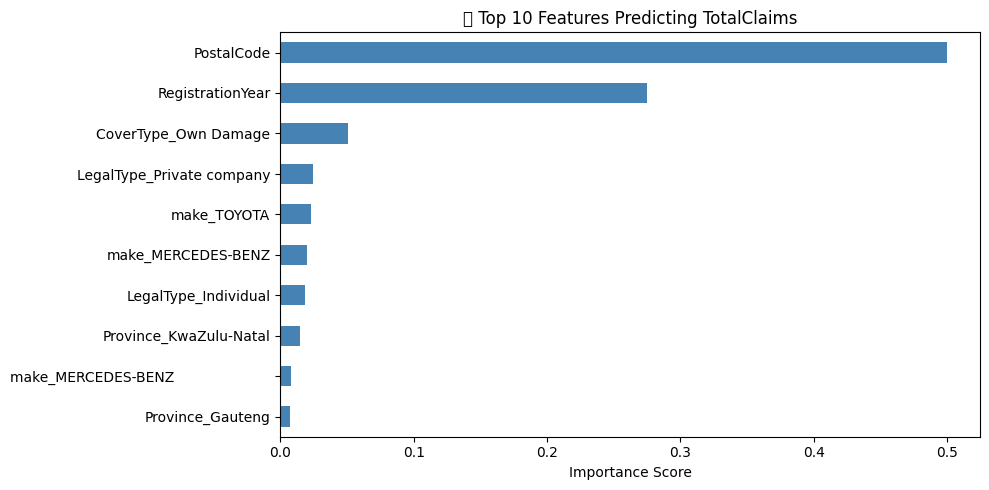

In [5]:
# --- Train-Test Split (80/20) ---
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y_claims, test_size=0.2, random_state=42)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X, y_premium, test_size=0.2, random_state=42)

# --- Model 1: Predict TotalClaims ---
rf_claim = RandomForestRegressor(random_state=42)
rf_claim.fit(Xc_train, yc_train)
yc_pred = rf_claim.predict(Xc_test)

print("\n🎯 TotalClaims Model Performance:")
mse = mean_squared_error(yc_test, yc_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R² Score:", r2_score(yc_test, yc_pred))

# --- Model 2: Predict CalculatedPremiumPerTerm ---
rf_premium = RandomForestRegressor(random_state=42)
rf_premium.fit(Xp_train, yp_train)
yp_pred = rf_premium.predict(Xp_test)

print("\n💰 Premium Estimation Model Performance:")
mse = mean_squared_error(yp_test, yp_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

print("R² Score:", r2_score(yp_test, yp_pred))

# Feature Importance for Claims Model ---
importances = pd.Series(rf_claim.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(10, 5))
top_features.plot(kind='barh', color='steelblue')
plt.title('🔍 Top 10 Features Predicting TotalClaims')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)


🧪 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199355
           1       0.00      0.00      0.00       555

    accuracy                           1.00    199910
   macro avg       0.50      0.50      0.50    199910
weighted avg       0.99      1.00      1.00    199910

ROC AUC Score: 0.6808043688643624


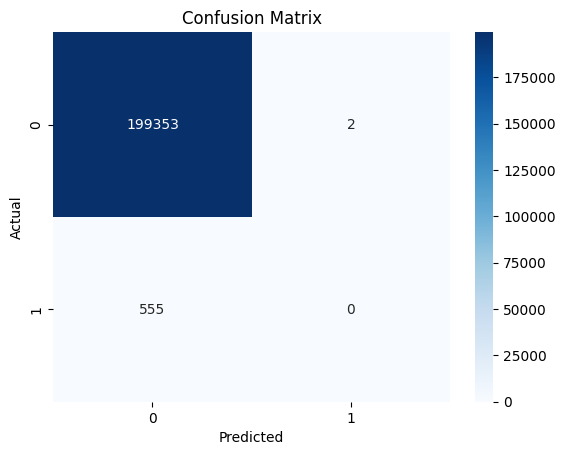

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Create classification label ---
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# --- Drop rows with missing values in features ---
df_class = df.dropna(subset=features + ['HasClaim'])

# --- Feature encoding ---
X = pd.get_dummies(df_class[features], drop_first=True)
y = df_class['HasClaim']

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Train Random Forest Classifier ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# --- Evaluate model ---
print("\n🧪 Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


              precision    recall  f1-score   support

           0       1.00      0.89      0.94    199355
           1       0.01      0.46      0.02       555

    accuracy                           0.89    199910
   macro avg       0.50      0.68      0.48    199910
weighted avg       1.00      0.89      0.94    199910

ROC AUC Score: 0.6826874824462044


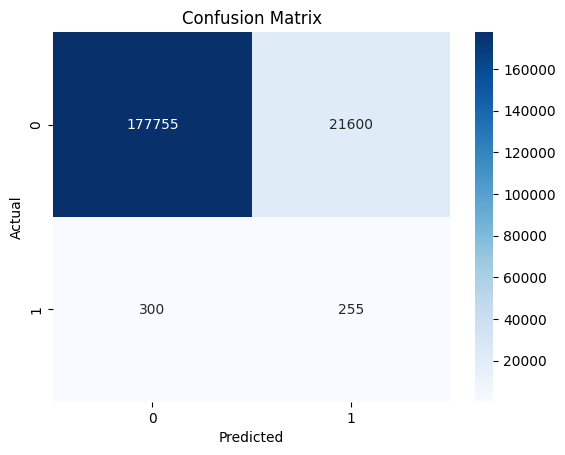

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Create classification label ---
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# --- Drop rows with missing values in features ---
df_class = df.dropna(subset=features + ['HasClaim'])

# --- Feature encoding ---
X = pd.get_dummies(df_class[features], drop_first=True)
y = df_class['HasClaim']

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Re-train with class_weight
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.2).astype(int)  # Adjust threshold

# Evaluate again
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




🎯 Claim Severity Model (only claimers):
RMSE: 35570.83
R² Score: 0.1115


C:\Users\mike\AppData\Local\Temp\ipykernel_11160\3723086564.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


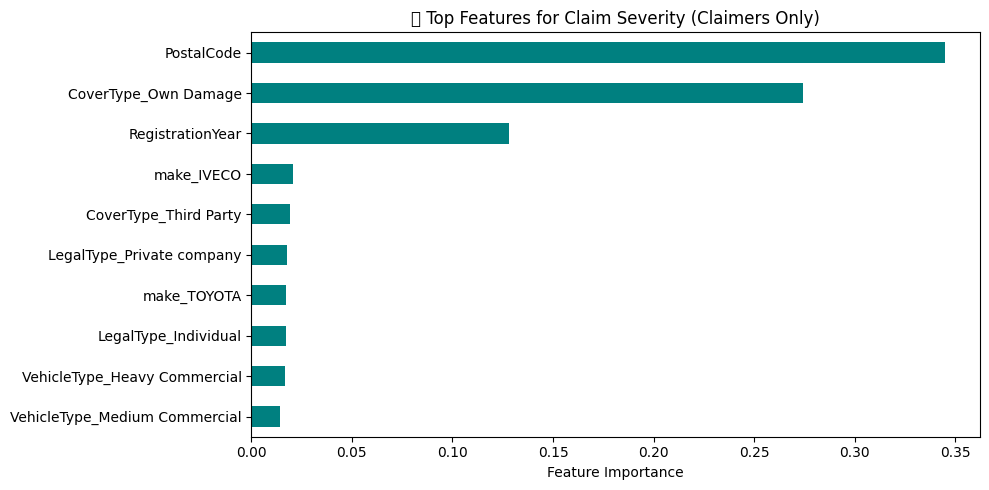

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Filter dataset to only customers with claims ---
df_severity = df[(df['TotalClaims'] > 0)].dropna(subset=features + ['TotalClaims'])

# --- Feature encoding ---
X = pd.get_dummies(df_severity[features], drop_first=True)
y = df_severity['TotalClaims']

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the model ---
rf_severity = RandomForestRegressor(n_estimators=100, random_state=42)
rf_severity.fit(X_train, y_train)
y_pred = rf_severity.predict(X_test)

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🎯 Claim Severity Model (only claimers):")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

#  Feature importance plot ---
importances = pd.Series(rf_severity.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(10, 5))
top_features.plot(kind='barh', color='teal')
plt.title('🔍 Top Features for Claim Severity (Claimers Only)')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
#  Crate a new feature: VehicleAgeAtTransaction

df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

# Calculate vehicle age at the time of the transaction
df['VehicleAgeAtTransaction'] = df['TransactionMonth'].dt.year - df['RegistrationYear']

# Cap negative ages at 0.
df['VehicleAgeAtTransaction'] = df.apply(lambda row: max(0, row['VehicleAgeAtTransaction']), axis=1)

print("\n'VehicleAgeAtTransaction' feature created:")
print(df[['RegistrationYear', 'TransactionMonth', 'VehicleAgeAtTransaction']].head())


'VehicleAgeAtTransaction' feature created:
   RegistrationYear TransactionMonth  VehicleAgeAtTransaction
0              2004       2015-03-01                       11
1              2004       2015-05-01                       11
2              2004       2015-07-01                       11
3              2004       2015-05-01                       11
4              2004       2015-07-01                       11



Training data shape: (798988, 86)
Testing data shape: (199748, 86)

Calculated scale_pos_weight: 359.23
This tells XGBoost to weight each 'HasClaim=1' sample more heavily.

Training XGBoost model with early stopping...


c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:38:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Model training complete.

--- XGBoost Model Evaluation ---
ROC AUC Score: 0.8888

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    199193
           1       0.01      0.88      0.02       555

    accuracy                           0.79    199748
   macro avg       0.51      0.84      0.45    199748
weighted avg       1.00      0.79      0.88    199748



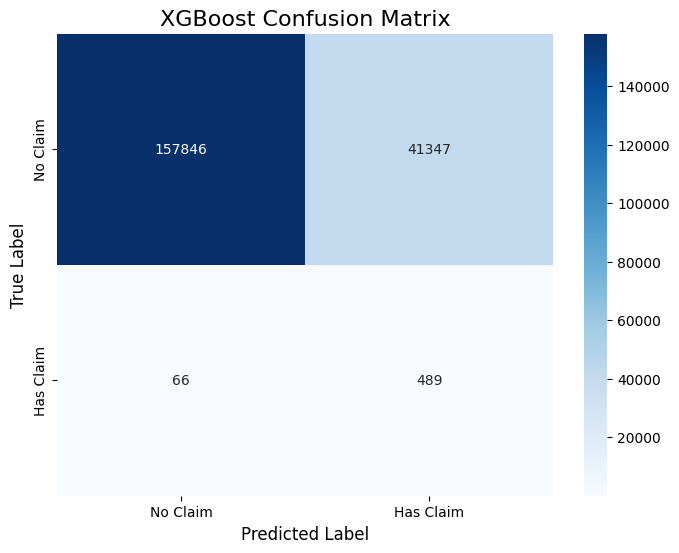

In [23]:
# Added the new feature
features = [
    'VehicleAgeAtTransaction', # new feature
    'PostalCode',
    'LegalType',
    'GenderFilled',
    'Province',
    'CoverType',
    'VehicleType',
    'make'
]

# Define the target variable
target = 'HasClaim'

# Prepare the data for modeling
# Drop rows with missing values in the selected features or target
df_model = df.dropna(subset=features + [target])

# Separate features (X) and target (y)
X = pd.get_dummies(df_model[features], drop_first=True)
y = df_model[target]

# --- 5. Train-Test Split ---
# Split the data into training and testing sets (80/20 split)
# 'stratify=y' is crucial for imbalanced datasets to ensure both train and test sets
# have a similar proportion of target classes.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


# --- 6. Train the XGBoost Classifier ---
# XGBoost is excellent for handling imbalanced data.
# We will calculate 'scale_pos_weight' to tell the model to pay more attention
# to the minority class (customers with claims).
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.2f}")
print("This tells XGBoost to weight each 'HasClaim=1' sample more heavily.")

# Initialize the XGBoost model with optimized parameters for this problem
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic', # Objective for binary classification
    n_estimators=1000,           # Number of trees
    max_depth=5,                 # Maximum depth of a tree
    learning_rate=0.05,          # Step size shrinkage
    scale_pos_weight=scale_pos_weight_value, # Handle class imbalance
    use_label_encoder=False,   
    early_stopping_rounds=50,  # Suppress a deprecation warning
    eval_metric='logloss',       # Evaluation metric for the learning process
    random_state=42,             # For reproducibility
    n_jobs=-1                    # Use all available CPU cores
)

# Train the model with early stopping to prevent overfitting
# The model will stop training if the validation loss doesn't improve for 50 rounds.
print("\nTraining XGBoost model with early stopping...")
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Set to True to see training progress
)
print("Model training complete.")


# --- 7. Evaluate the XGBoost Model ---
# Make predictions on the test data
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1] # Probabilities for the positive class

print("\n--- XGBoost Model Evaluation ---")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Claim', 'Has Claim'],
            yticklabels=['No Claim', 'Has Claim'])
plt.title('XGBoost Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()



--- Generating SHAP Interpretability Plots ---
Calculating SHAP values... (this may take a minute)
SHAP values calculated.


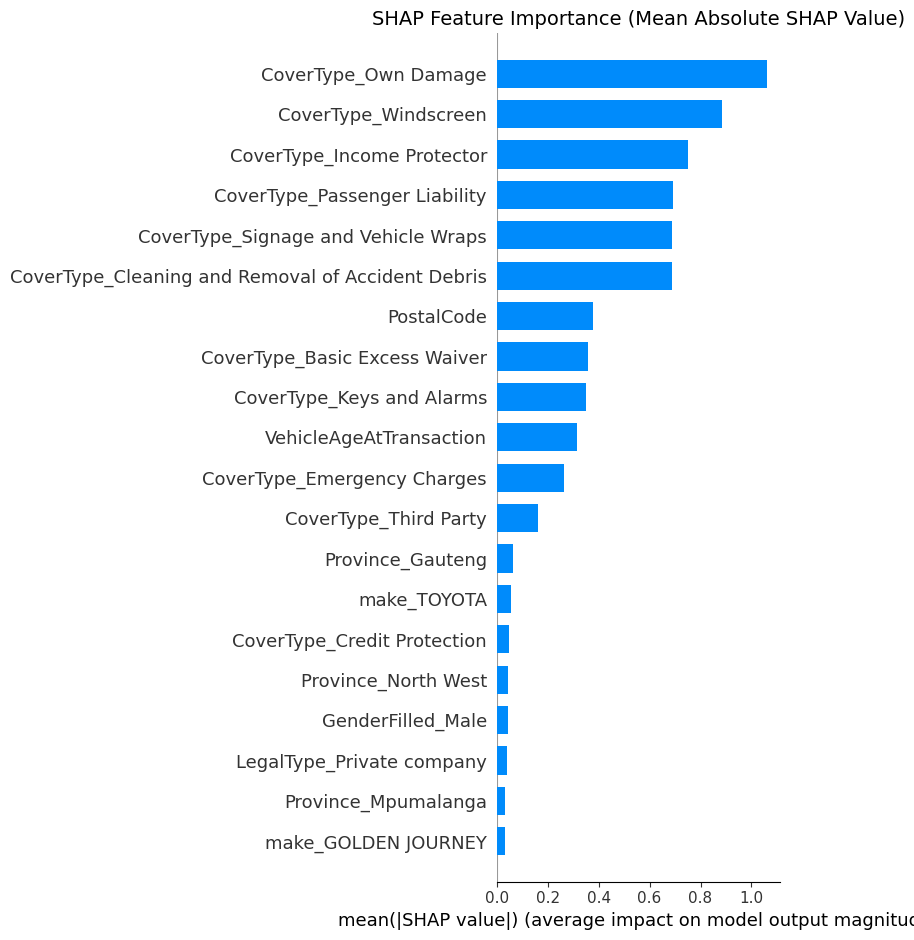

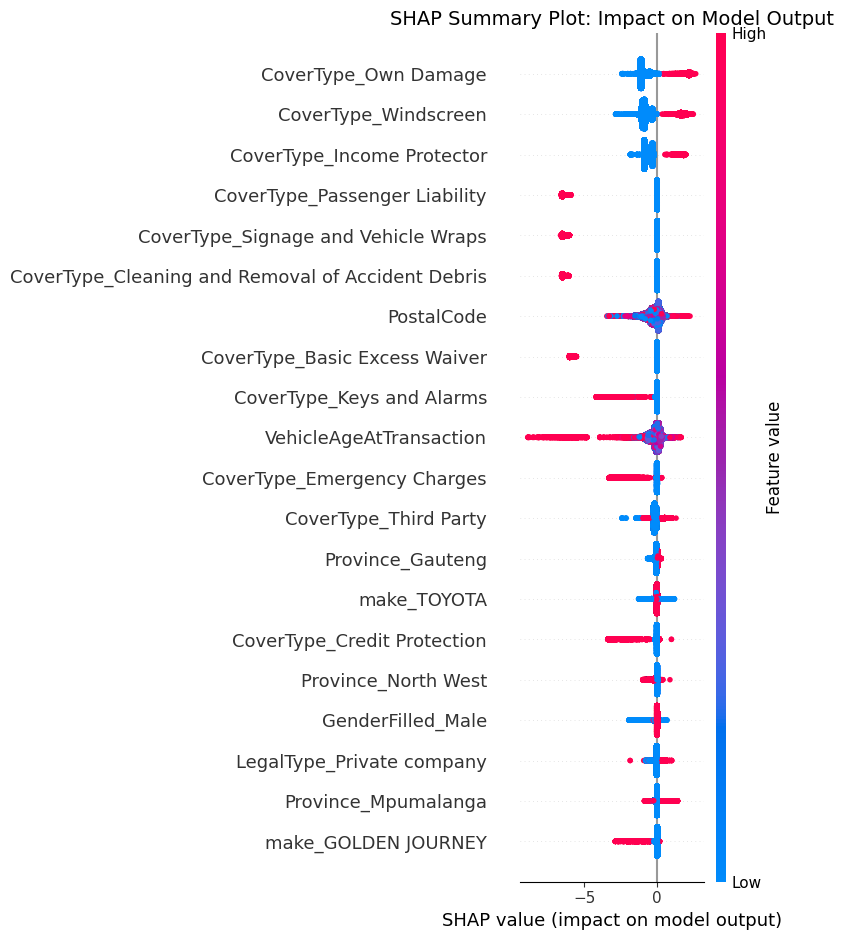


Analysis complete. The SHAP plots provide deep insights into what drives claim predictions.


In [24]:
# --- 8. Apply SHAP for Model Interpretability ---
print("\n--- Generating SHAP Interpretability Plots ---")
# SHAP (SHapley Additive exPlanations) explains the output of machine learning models.

# Create a SHAP explainer object for our XGBoost model
explainer = shap.TreeExplainer(xgb_clf)

# Calculate SHAP values for the test set. This can take a moment.
print("Calculating SHAP values... (this may take a minute)")
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated.")


# Plot 1: SHAP Feature Importance (Bar Plot)
# This shows the average impact of each feature on the model's output magnitude.
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    show=False
)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Value)', fontsize=14)
plt.tight_layout()
plt.show()


# Plot 2: SHAP Summary Plot (Beeswarm)
# This is the most powerful SHAP plot. It shows not only the importance
# but also the direction and distribution of each feature's impact.
# - Each dot is a customer from the test set.
# - Color indicates the feature's value (red=high, blue=low).
# - X-axis is the SHAP value: positive values push the prediction towards "Has Claim",
#   negative values push it towards "No Claim".
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    show=False
)
plt.title('SHAP Summary Plot: Impact on Model Output', fontsize=14)
plt.tight_layout()
plt.show()

print("\nAnalysis complete. The SHAP plots provide deep insights into what drives claim predictions.")